In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [61]:
# Load merged dataset
df = pd.read_csv("Merged_dataset.csv")

# 🔹 Remove rare adsorbate (C2 H2 O1 occurs only once)
df = df[df["Adsorbate IUPAC Formula"] != "C2 H2 O1"].copy()

# Basic info
print("✅ Dataset loaded and cleaned successfully")
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())

# Quick preview
display(df.head())


✅ Dataset loaded and cleaned successfully
Shape: (1781, 11)
Columns: ['Catalyst ID', 'Formula', 'Bulk Material ID', 'Element', 'Adsorbate Smiles', 'Adsorbate IUPAC Formula', 'Adsorption Energy', 'h', 'k', 'l', 'Surface Shift']


,Catalyst ID,Formula,Bulk Material ID,Element,Adsorbate Smiles,Adsorbate IUPAC Formula,Adsorption Energy,h,k,l,Surface Shift
0,random2372905,Ni₂₄H₃C₂,mp-1094136,Ni,*CHCH2,C2 H3,-2.863,1,1,0.0,0.250
1,random1867915,Ni₄₈HN₂,mp-1014111,Ni,*N*NH,N2 H1,-0.837,2,2,1.0,0.019
2,random2070538,Au₂₄N,mp-1008634,Au,*N2,N2,-0.009,1,1,0.0,0.250
3,random2198215,Cu₇₂O,mp-1120774,Cu,*O,O1,0.488,2,-1,2.0,0.000
4,random458621,Cu₇₂H₃(CO)₂,mp-1120774,Cu,*CHOCHOH,C2 H3 O2,-1.686,1,1,1.0,0.166


In [62]:
from sklearn.impute import SimpleImputer

# Features (X) and Target (y)
X = df[["Element", "Adsorbate Smiles", "h", "k", "l", "Surface Shift"]]
y = df["Adsorption Energy"]

# Preprocessor with Imputer
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent")),   # fill missing categorical
            ("encoder", OneHotEncoder(handle_unknown="ignore"))
        ]), ["Element", "Adsorbate Smiles"]),
        
        ("num", Pipeline([
            ("imputer", SimpleImputer(strategy="mean")),            # fill missing numeric
            ("scaler", StandardScaler())
        ]), ["h", "k", "l", "Surface Shift"])
    ]
)

print("✅ Preprocessing pipeline with Imputer ready")


✅ Preprocessing pipeline with Imputer ready


In [63]:
# Split into train and test sets
try:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=X["Element"]
    )
except ValueError:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

print("✅ Dataset split complete")
print("Train size:", X_train.shape[0])
print("Test size :", X_test.shape[0])


✅ Dataset split complete
Train size: 1424
Test size : 357


In [64]:
from sklearn.linear_model import LinearRegression

# Define pipeline
linreg_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", LinearRegression())
])

# Train
linreg_model.fit(X_train, y_train)

# Predict
y_pred = linreg_model.predict(X_test)

# Evaluate
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)   # compute RMSE manually
r2 = r2_score(y_test, y_pred)

print("📊 Linear Regression Performance")
print(f"MAE  : {mae:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"R²   : {r2:.4f}")



📊 Linear Regression Performance
MAE  : 0.5160
RMSE : 0.8518
R²   : 0.8399


In [65]:
from sklearn.ensemble import RandomForestRegressor

# Build pipeline
rf_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", RandomForestRegressor(random_state=42))
])

# Train
rf_model.fit(X_train, y_train)

# Predict
y_pred = rf_model.predict(X_test)

# Evaluate
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)   # RMSE manually
r2 = r2_score(y_test, y_pred)

print("📊 Random Forest Performance")
print(f"MAE  : {mae:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"R²   : {r2:.4f}")


📊 Random Forest Performance
MAE  : 0.5007
RMSE : 0.9193
R²   : 0.8135


In [66]:
from sklearn.model_selection import GridSearchCV

# Parameter grid
param_grid = {
    "regressor__n_estimators": [100, 200, 300],
    "regressor__max_depth": [None, 10, 20],
    "regressor__min_samples_split": [2, 5, 10],
    "regressor__min_samples_leaf": [1, 2, 4],
}

# Pipeline with RF
rf_model_tuned = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", RandomForestRegressor(random_state=42))
])

# Grid search
grid_search = GridSearchCV(
    rf_model_tuned,
    param_grid,
    cv=3,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)

# Predict
y_pred = grid_search.predict(X_test)

# Evaluate
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)   # RMSE manually
r2 = r2_score(y_test, y_pred)

print("\n📊 Tuned Random Forest Performance")
print(f"MAE  : {mae:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"R²   : {r2:.4f}")


Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best parameters: {'regressor__max_depth': None, 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 10, 'regressor__n_estimators': 200}

📊 Tuned Random Forest Performance
MAE  : 0.4938
RMSE : 0.8998
R²   : 0.8214


In [67]:
from sklearn.ensemble import GradientBoostingRegressor

# Build pipeline
gb_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", GradientBoostingRegressor(random_state=42))
])

# Train
gb_model.fit(X_train, y_train)

# Predict
y_pred = gb_model.predict(X_test)

# Evaluate
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)   # RMSE manually
r2 = r2_score(y_test, y_pred)

print("📊 Gradient Boosting Performance")
print(f"MAE  : {mae:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"R²   : {r2:.4f}")


📊 Gradient Boosting Performance
MAE  : 0.8738
RMSE : 1.1719
R²   : 0.6970


In [68]:
import joblib

# Choose which model to save
best_model = grid_search.best_estimator_   # or rf_model, gb_model, linreg_model

# Save
joblib.dump(best_model, "best_model.pkl")
print("✅ Model saved as best_model.pkl")


✅ Model saved as best_model.pkl


In [69]:
# Load model
loaded_model = joblib.load("best_model.pkl")

# Example new input (customize this)
demo_data = pd.DataFrame([{
    "Element": "Cu",
    "Adsorbate Smiles": "O=O",   # Oxygen molecule
    "h": 1,
    "k": 1,
    "l": 1,
    "Surface Shift": 0
}])

# Predict
predicted_energy = loaded_model.predict(demo_data)[0]
print(f"🔮 Predicted Adsorption Energy: {predicted_energy:.3f} eV")


🔮 Predicted Adsorption Energy: -1.358 eV


📊 Model Comparison Table


,MAE,RMSE,R²
Linear Regression,0.515987,0.851780,0.839920
Random Forest,0.500749,0.919264,0.813550
Tuned Random Forest,0.493784,0.899796,0.821364
Gradient Boosting,0.873767,1.171852,0.697011


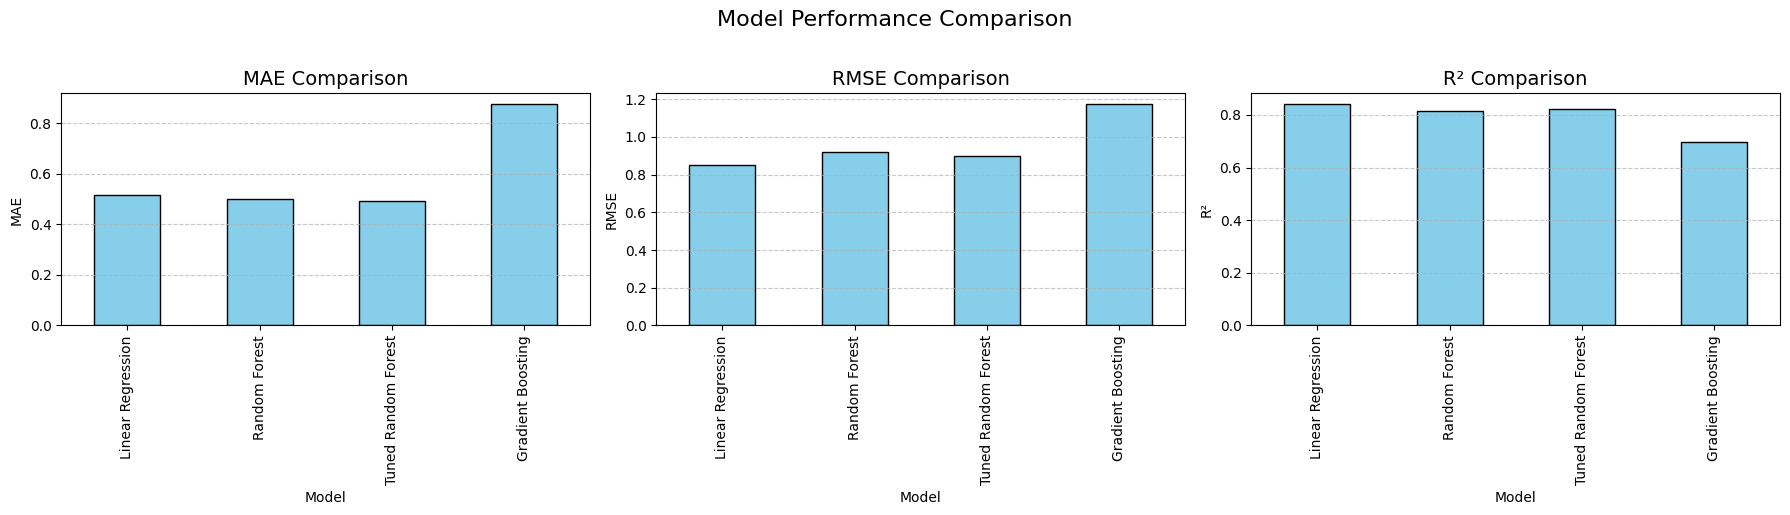

In [70]:
# 📊 Cell 11: Compare all models graphically
import matplotlib.pyplot as plt
import numpy as np

# Collect results in a dictionary
results = {
    "Linear Regression": {
        "MAE": mean_absolute_error(y_test, linreg_model.predict(X_test)),
        "RMSE": np.sqrt(mean_squared_error(y_test, linreg_model.predict(X_test))),
        "R²": r2_score(y_test, linreg_model.predict(X_test)),
    },
    "Random Forest": {
        "MAE": mean_absolute_error(y_test, rf_model.predict(X_test)),
        "RMSE": np.sqrt(mean_squared_error(y_test, rf_model.predict(X_test))),
        "R²": r2_score(y_test, rf_model.predict(X_test)),
    },
    "Tuned Random Forest": {
        "MAE": mean_absolute_error(y_test, grid_search.predict(X_test)),
        "RMSE": np.sqrt(mean_squared_error(y_test, grid_search.predict(X_test))),
        "R²": r2_score(y_test, grid_search.predict(X_test)),
    },
    "Gradient Boosting": {
        "MAE": mean_absolute_error(y_test, gb_model.predict(X_test)),
        "RMSE": np.sqrt(mean_squared_error(y_test, gb_model.predict(X_test))),
        "R²": r2_score(y_test, gb_model.predict(X_test)),
    },
}

# Convert to DataFrame for easier plotting
results_df = pd.DataFrame(results).T  # transpose so models are rows

print("📊 Model Comparison Table")
display(results_df)

# --- Plotting ---
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

metrics = ["MAE", "RMSE", "R²"]

for i, metric in enumerate(metrics):
    results_df[metric].plot(kind="bar", ax=axes[i], color="skyblue", edgecolor="black")
    axes[i].set_title(f"{metric} Comparison", fontsize=14)
    axes[i].set_ylabel(metric)
    axes[i].set_xlabel("Model")
    axes[i].grid(axis="y", linestyle="--", alpha=0.7)

plt.suptitle("Model Performance Comparison", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


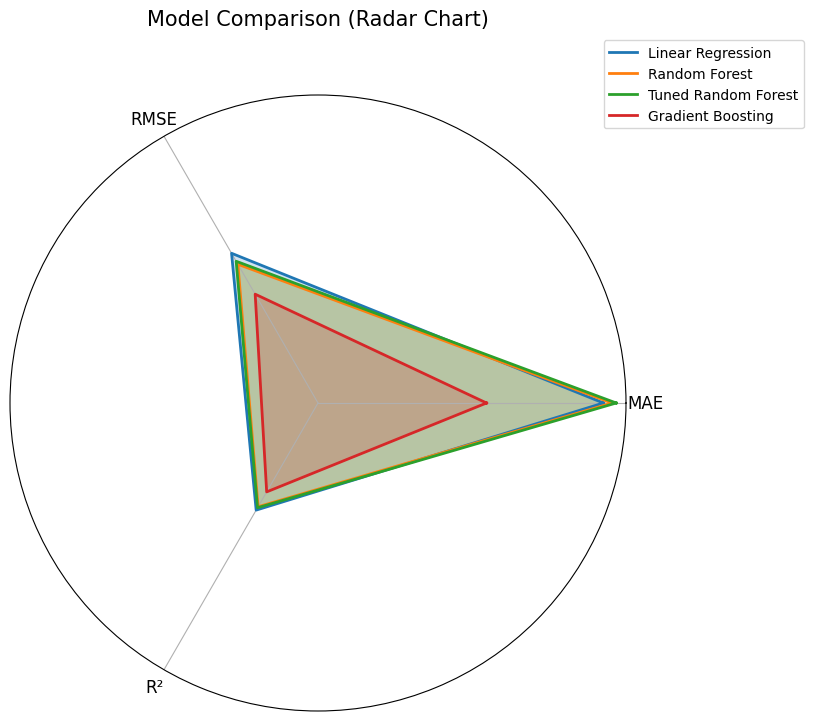

In [71]:
# 📊 Cell 12: Radar (Spider) Chart for Model Comparison
from math import pi

# Normalize metrics so that lower-is-better ones (MAE, RMSE) can be compared fairly
# We'll invert them by taking 1/value (scaled) so that higher is better for all metrics
norm_results = results_df.copy()
norm_results["MAE"] = 1 / norm_results["MAE"]
norm_results["RMSE"] = 1 / norm_results["RMSE"]
# R² is already "higher is better", keep as is

# Columns (metrics)
metrics = list(norm_results.columns)
N = len(metrics)

# Angles for each axis
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]  # complete the loop

# Plot
plt.figure(figsize=(8, 8))
ax = plt.subplot(111, polar=True)

for model in norm_results.index:
    values = norm_results.loc[model].values.flatten().tolist()
    values += values[:1]  # loop back to start
    ax.plot(angles, values, label=model, linewidth=2)
    ax.fill(angles, values, alpha=0.2)

# Labels
plt.xticks(angles[:-1], metrics, fontsize=12)
ax.set_rlabel_position(0)
plt.yticks([], [])  # hide scale
plt.title("Model Comparison (Radar Chart)", size=15, y=1.1)
plt.legend(loc="upper right", bbox_to_anchor=(1.3, 1.1))

plt.show()
